
## **Burgers' Equation: Inverse Continuous Problem**

In this notebook, we solve the inverse problem for the 1D Burgers' equation.

**Goal:** Given a small set of noisy measurement data for `u(x, t)`, discover the unknown parameters of the governing PDE.

**Methodology:**
We define the PDE with unknown coefficients `lambda_1` and `lambda_2`. The PINN will learn the solution `u(x,t)` and the values of these parameters simultaneously by minimizing the loss function.

The governing equation is assumed to be:
 $$u_t + \lambda_1 u u_x - \lambda_2 u_{xx} = 0$$

Our goal is to train the model and find that $\lambda_1 \approx 1.0$ and $\lambda_2 \approx \nu = 0.01/\pi$.


## **1 Imports, Setup and Configuration**

In [2]:
# Import necessary libraries and our custom modules from the src directory.
import sys
import torch
import torch.nn as nn
import numpy as np
import time

# Add the src directory to the system path
sys.path.insert(0, '../../src/')

from models import PhysicsInformedNN
from utilities import load_data, relative_l2_error, setup_seed
from visualisation import plot_solution_heatmap, plot_snapshots

# Set up for reproducibility and device configuration
setup_seed(1234)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Here, we define the parameters for the inverse problem experiment. We use a smaller number of training points (`N_u`) and introduce noise to simulate a realistic scenario.

# Number of training data points
N_u = 2000 # Number of data points sampled from the solution
noise_level = 0.01 # Percentage of noise to add to the data

# Path to the data file
data_path = '../../data/burgers_shock.mat'


Using device: cpu


## **2 Data Loading and Preparation**

In [3]:
# We load the full dataset, then sample a small number of points and add noise to them. This noisy, sparse data is all the model will see.
data = load_data(data_path)

# Extract data and convert to float32
t = data['t'].flatten()[:,None].astype(np.float32)
x = data['x'].flatten()[:,None].astype(np.float32)
Exact = np.real(data['usol']).T.astype(np.float32)

# Create a grid for the entire domain
X, T = np.meshgrid(x, t)
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]

# Domain bounds
lb = X_star.min(0)
ub = X_star.max(0)

# --- Training Data ---
# For the inverse problem, we sample directly from the entire solution field
idx = np.random.choice(X_star.shape[0], N_u, replace=False)
X_u_train = X_star[idx, :]
u_train = u_star[idx, :]

# Add noise to the training data
noise = noise_level * np.std(u_train) * np.random.randn(*u_train.shape)
u_train = u_train + noise

# --- Convert to Tensors ---
# Note: For the inverse problem, all training data are "data points".
# We still need collocation points for the physics loss, which will be the same set.
X_u_train_t = torch.tensor(X_u_train, dtype=torch.float32).to(device)
u_train_t = torch.tensor(u_train, dtype=torch.float32).to(device)
X_star_t = torch.tensor(X_star, dtype=torch.float32).to(device)
u_star_t = torch.tensor(u_star, dtype=torch.float32).to(device)

# The collocation points for the physics loss are the same as the training points
X_f_train_t = X_u_train_t.clone()
X_f_train_t.requires_grad = True

print(f"Total points in domain: {X_star.shape[0]}")
print(f"Training data points: {X_u_train_t.shape[0]}")



Total points in domain: 25600
Training data points: 2000


## **3 Model and Loss Function Definition**

In [ ]:
# This is the core of the inverse problem. We define `lambda_1` and `lambda_2` as `torch.nn.Parameter`, making them learnable. The loss function now includes these parameters in the PDE residual calculation.

# Define the PINN architecture
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
lb_t = torch.tensor(lb, dtype=torch.float32).to(device)
ub_t = torch.tensor(ub, dtype=torch.float32).to(device)

pinn_model = PhysicsInformedNN(layers, lb_t, ub_t).to(device)

# --- Define Learnable PDE Parameters ---
# Initialize with values that are not the solution (e.g., 0.0 and log(0.1))
# We use log for lambda_2 to ensure it remains positive, as viscosity must be positive.
lambda_1 = nn.Parameter(torch.tensor([0.0], device=device))
lambda_2_log = nn.Parameter(torch.tensor([np.log(0.1)], device=device)) # Learn in log space

# Loss function
def combined_loss_fn():
    lambda_2 = torch.exp(lambda_2_log) # Ensure positivity
    
    # Data loss
    u_pred = pinn_model(X_u_train_t)
    loss_data = torch.mean((u_train_t - u_pred)**2)
    
    # Physics loss
    u_phy = pinn_model(X_f_train_t)
    grads = torch.autograd.grad(u_phy, X_f_train_t, grad_outputs=torch.ones_like(u_phy), create_graph=True)[0]
    u_x, u_t = grads[:, 0:1], grads[:, 1:2]
    u_xx = torch.autograd.grad(u_x, X_f_train_t, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0:1]
    
    # PDE residual with learnable parameters
    residual = u_t + lambda_1 * u_phy * u_x - lambda_2 * u_xx
    loss_pde = torch.mean(residual**2)
    
    return loss_data + loss_pde



## **4 Training - hybrid Adam + L-BFGS trainer**

We use the hybrid Adam + L-BFGS trainer. Crucially, the optimizer is now responsible for updating not only the network's weights but also our two `lambda` parameters.

In [6]:
# Combine all learnable parameters
params = list(pinn_model.parameters()) + [lambda_1, lambda_2_log]

# Setup optimizers
optimizer_adam = torch.optim.Adam(params, lr=1e-3)
optimizer_lbfgs = torch.optim.LBFGS(
    params,
    max_iter=50000,
    max_eval=50000,
    history_size=50,
    tolerance_grad=1e-5,
    tolerance_change=1.0 * np.finfo(float).eps,
    line_search_fn="strong_wolfe"
)

# --- Custom Training Loop for Monitoring Lambdas ---
print("--- Starting Adam Optimization ---")
start_time = time.time()
adam_epochs = 10000
loss_history = []

for epoch in range(adam_epochs):
    optimizer_adam.zero_grad()
    loss = combined_loss_fn()
    loss.backward()
    optimizer_adam.step()
    loss_history.append(loss.item())
    
    if (epoch + 1) % 1000 == 0:
        elapsed = time.time() - start_time
        print(f"Adam Epoch: {epoch+1}/{adam_epochs}, Loss: {loss.item():.4e}, "
              f"l1: {lambda_1.item():.4f}, l2: {torch.exp(lambda_2_log).item():.6f}, Time: {elapsed:.2f}s")
        start_time = time.time()

print("\n--- Starting L-BFGS Optimization ---")
def closure():
    optimizer_lbfgs.zero_grad()
    loss = combined_loss_fn()
    loss.backward()
    loss_history.append(loss.item())
    return loss

optimizer_lbfgs.step(closure)

final_loss = combined_loss_fn()
print(f"L-BFGS Final Loss: {final_loss.item():.4e}")



--- Starting Adam Optimization ---
Adam Epoch: 1000/10000, Loss: 2.4895e-02, l1: 0.6553, l2: 0.043025, Time: 149.19s
Adam Epoch: 2000/10000, Loss: 8.0076e-03, l1: 0.9508, l2: 0.024398, Time: 202.50s
Adam Epoch: 3000/10000, Loss: 3.8586e-03, l1: 0.9836, l2: 0.016066, Time: 144.60s
Adam Epoch: 4000/10000, Loss: 2.5631e-03, l1: 0.9886, l2: 0.011881, Time: 94.93s
Adam Epoch: 5000/10000, Loss: 1.4777e-03, l1: 0.9885, l2: 0.009725, Time: 110.11s
Adam Epoch: 6000/10000, Loss: 1.0721e-03, l1: 0.9942, l2: 0.008477, Time: 157.89s
Adam Epoch: 7000/10000, Loss: 8.2202e-04, l1: 0.9944, l2: 0.007643, Time: 216.35s
Adam Epoch: 8000/10000, Loss: 7.1513e-04, l1: 0.9847, l2: 0.007201, Time: 204.46s
Adam Epoch: 9000/10000, Loss: 9.1053e-04, l1: 0.9974, l2: 0.006763, Time: 83.38s
Adam Epoch: 10000/10000, Loss: 7.0268e-04, l1: 0.9362, l2: 0.006524, Time: 111.54s

--- Starting L-BFGS Optimization ---
L-BFGS Final Loss: 3.7791e-05


## **5 Results and Visualization**

After training, we check the discovered values of our PDE parameters and compare them to the true values. We also plot the learned solution to ensure it's accurate.


--- Parameter Identification Results ---
True lambda_1: 1.0
Predicted lambda_1: 0.9985
Error: 0.15%

True lambda_2 (nu): 0.003183
Predicted lambda_2: 0.003177
Error: 0.21%

Relative L2 Error for Solution u: 1.8919e-03


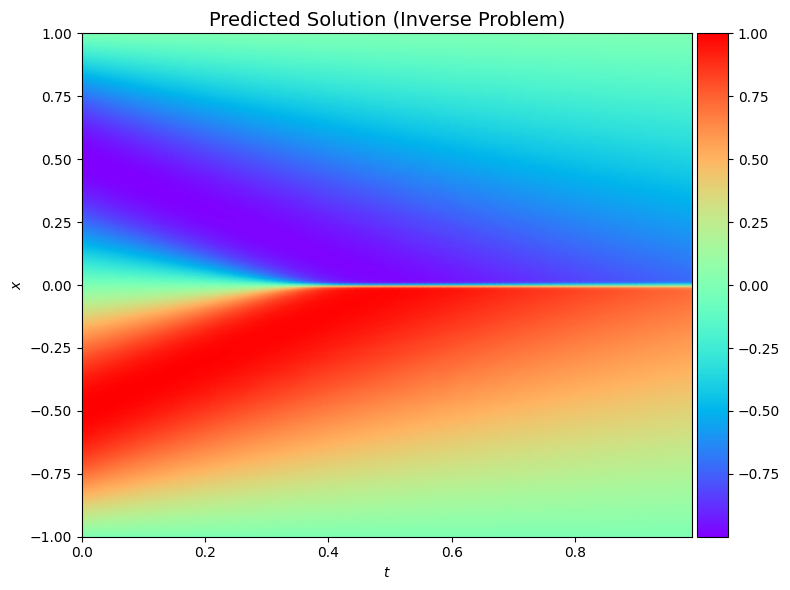

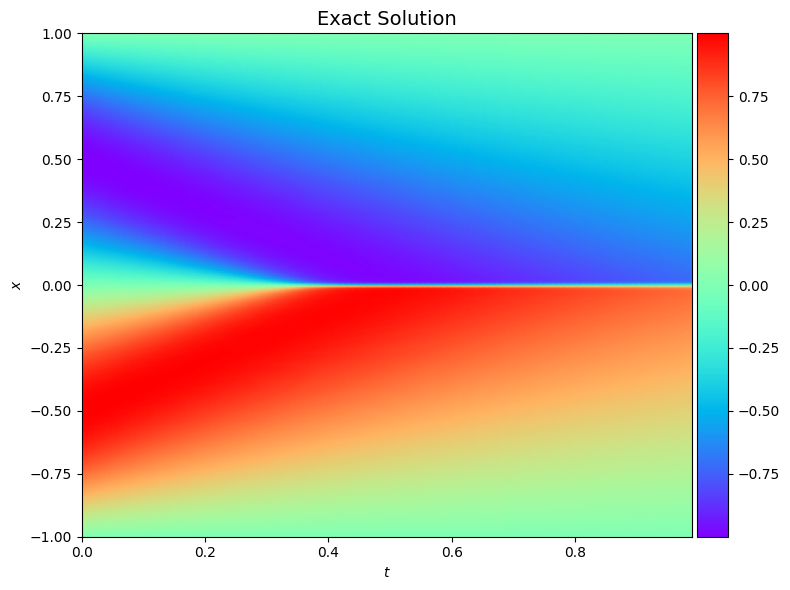

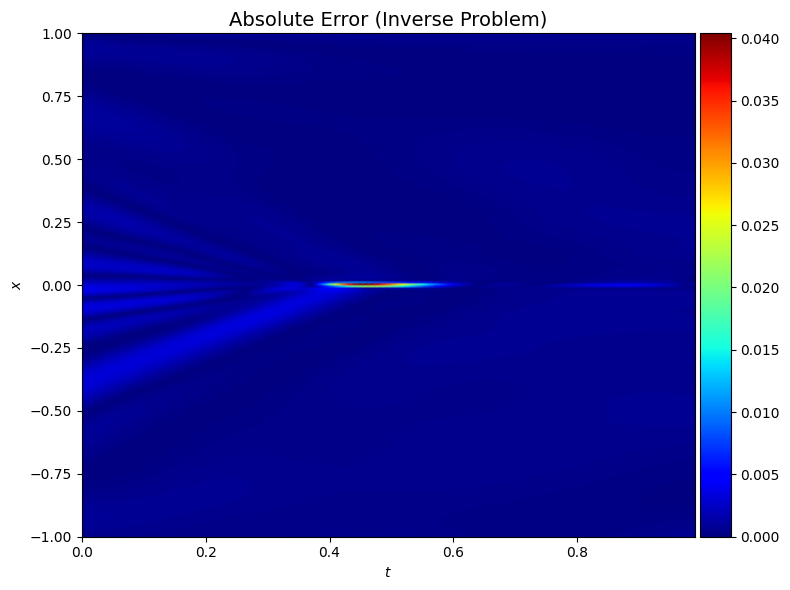

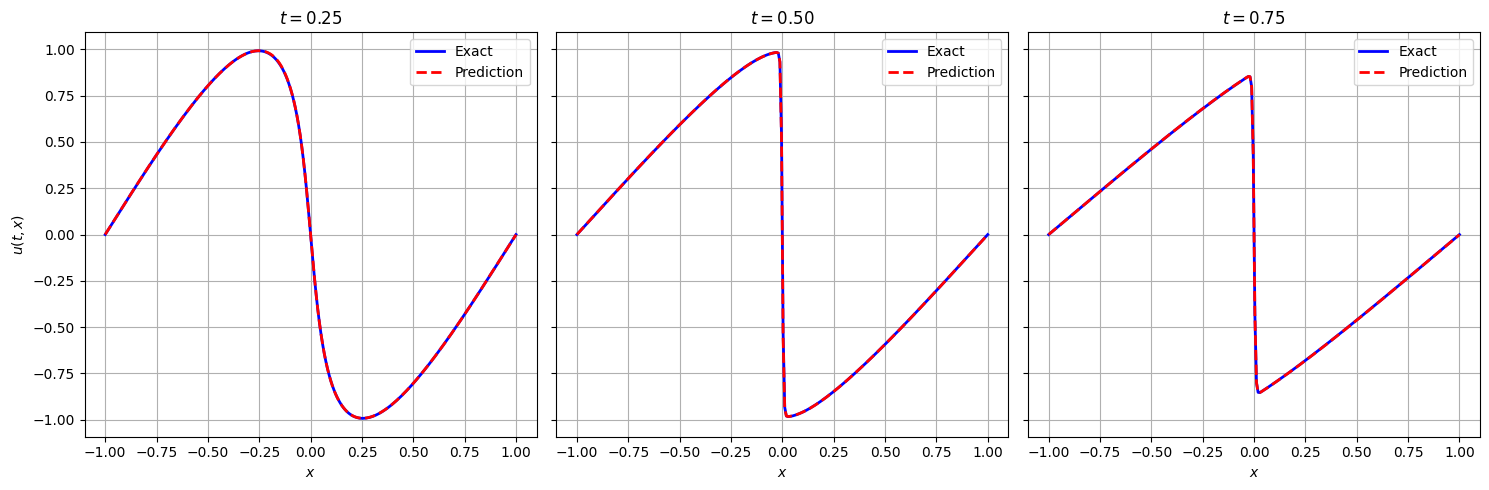

In [7]:

# --- Parameter Identification Results ---
lambda_1_pred = lambda_1.item()
lambda_2_pred = torch.exp(lambda_2_log).item()
nu_true = 0.01 / np.pi

error_lambda_1 = np.abs(lambda_1_pred - 1.0) * 100
error_lambda_2 = np.abs(lambda_2_pred - nu_true) / nu_true * 100

print("--- Parameter Identification Results ---")
print(f"True lambda_1: 1.0")
print(f"Predicted lambda_1: {lambda_1_pred:.4f}")
print(f"Error: {error_lambda_1:.2f}%\n")

print(f"True lambda_2 (nu): {nu_true:.6f}")
print(f"Predicted lambda_2: {lambda_2_pred:.6f}")
print(f"Error: {error_lambda_2:.2f}%")

# --- Solution Prediction and Visualization ---
pinn_model.eval()
with torch.no_grad():
    u_pred = pinn_model(X_star_t)

error_u = relative_l2_error(u_pred, u_star_t)
print(f"\nRelative L2 Error for Solution u: {error_u:.4e}")

# Reshape for plotting
from scipy.interpolate import griddata
u_pred_grid = griddata(X_star, u_pred.cpu().numpy().flatten(), (X, T), method='cubic')

# Plotting
plot_solution_heatmap(x, t, u_pred_grid, title="Predicted Solution (Inverse Problem)")
plot_solution_heatmap(x, t, Exact, title="Exact Solution")
plot_solution_heatmap(x, t, np.abs(Exact - u_pred_grid), title="Absolute Error (Inverse Problem)", cmap='jet')
plot_snapshots(x, t, Exact, u_pred_grid, snapshot_times=[0.25, 0.50, 0.75])



### **Conclusion and Analysis**

In this notebook, we tackled the inverse problem for the Burgers' equation. The goal was to leverage a Physics-Informed Neural Network (PINN) to discover the unknown physical parameters, $\lambda_1$ and $\lambda_2$, using only sparse and noisy measurement data for the solution $u(x,t)$.

#### **Parameter Identification Results**

The model was trained on 2,000 data points with 1% noise. The hybrid Adam + L-BFGS optimization strategy successfully identified the parameters with high accuracy:

* **Identified PDE:** $u_t + 0.9985 u u_x - 0.003177 u_{xx} = 0$
* **True PDE:** $u_t + 1.0 u u_x - 0.003183 u_{xx} = 0$

The specific errors were:
* **Error in $\lambda_1$ (convection):** 0.15%
* **Error in $\lambda_2$ (viscosity):** 0.21%

Furthermore, while discovering the PDE, the model also learned a highly accurate representation of the solution field itself, achieving a **relative L2 error of 1.89e-3**.

#### **Comparison to Benchmark**

Let's compare our results to those reported by the original authors, who trained on clean (noise-free) data:

* **Author's Identified PDE (Clean Data):**
    $u_t + 0.99915 u u_x - 0.0031794 u_{xx} = 0$
* **Our Identified PDE (Noisy Data):**
    $u_t + 0.9985 u u_x - 0.003177 u_{xx} = 0$

The comparison is remarkable. Our model, despite the significant challenge of working with noisy data, achieved a level of accuracy that is highly comparable to the results obtained on a clean dataset. The errors in our identified parameters are only marginally higher, demonstrating the robustness of the PINN methodology.

This experiment successfully shows that PINNs are a powerful tool for inverse problems. They can effectively filter out noise and uncover the underlying physical laws from a limited set of imperfect measurements, a task that is common and critical in many scientific and engineering disciplines. 